In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow as tf

import tqdm

from utils import normalize, closedLoop
from elman_opt import ElmanNetwork, save, load

2022-12-02 08:13:54.559726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 08:13:54.656615: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-02 08:13:54.660362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 08:13:54.660373: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

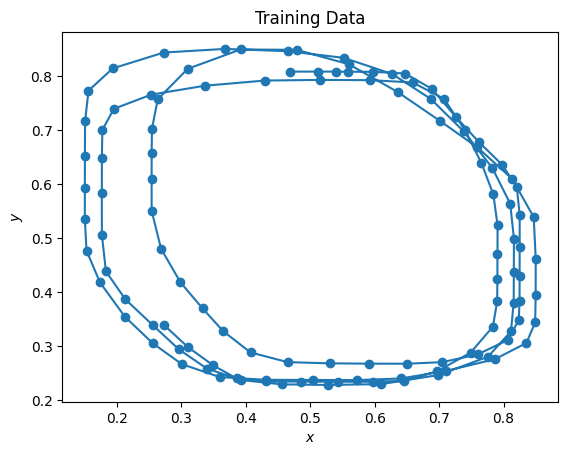

In [2]:
data = np.load('data/circle.npz')

dsFactor = 4

initialOffset = 150

xArr = normalize(data["positions"][initialOffset::dsFactor,0])
yArr = normalize(data["positions"][initialOffset::dsFactor,1])

xArr = xArr[:len(xArr)//4]
yArr = yArr[:len(yArr)//4]

plt.plot(xArr, yArr, '-o')
plt.title('Training Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [3]:
model = keras.Sequential()

model.add(layers.LSTM(15, return_sequences=True, activation='sigmoid'))
model.add(layers.Dropout(.2))
model.add(layers.LSTM(15, return_sequences=True, activation='sigmoid'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3))
#model.summary()

2022-12-02 08:10:51.448239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 08:10:51.448409: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 08:10:51.448425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Jack-Ubuntu): /proc/driver/nvidia/version does not exist
2022-12-02 08:10:51.448865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model = ElmanNetwork(inputDim=2,
                     contextDim=20,
                     outputDim=2,
                     optimizer='adam')

numEpochs = 1000

In [8]:
# These have a slightly different shape than in the homebrewed network, notably
# with an extra dimension in the middle. This doesn't actually change the amount
# of information provided, and any two arrays can easily be flipped with
# elmanArr = kerasArr[:,0,:]
# kerasArr = np.reshape(elmanArr, (elmanArr.shape[0], 1, elmanArr.shape[1]))
inputArr = np.reshape(np.array(list(zip(xArr, yArr)))[:-1], (1, len(xArr)-1, 2))
targetArr = np.reshape(np.array(list(zip(xArr, yArr)))[1:], (1, len(xArr)-1, 2))

print(np.shape(inputArr))
print(np.shape(targetArr))

errorArr = model.fit(inputArr, targetArr, epochs=numEpochs).history["loss"]

(1, 118, 2)
(1, 118, 2)


In [4]:
inputArr = np.array(list(zip(xArr, yArr)))[:-1]
targetArr = np.array(list(zip(xArr, yArr)))[1:]
errorArr = np.zeros(numEpochs) # list to store errors

for epoch in tqdm.tqdm(range(numEpochs)):
    # Context and output
    contextArr, outputArr = model.forwardSequence(inputArr)
    errorArr[epoch]  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
    model.updateParameters()


  0%|                                  | 0/1000 [00:00<?, ?it/s]<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
100%|███████████████████████| 1000/1000 [00:11<00:00, 83.41it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

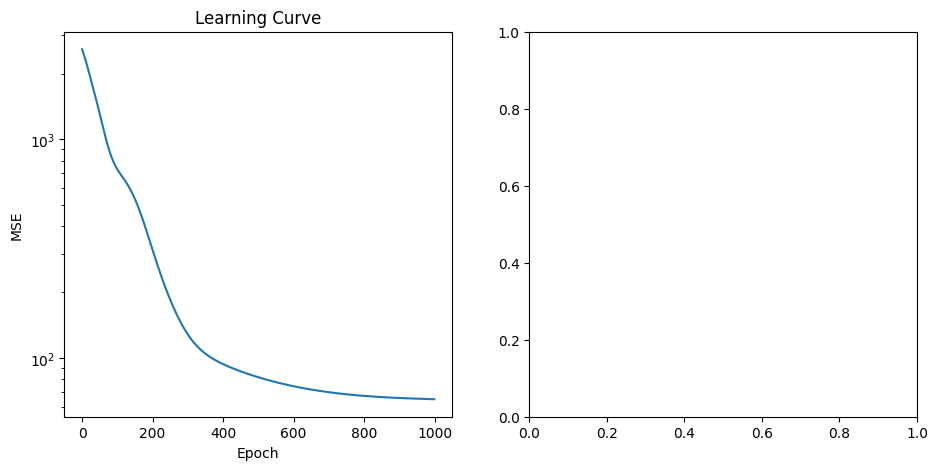

In [7]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

outputArr = model(inputArr[0])

ax[1].plot(targetArr[0,1:,0], alpha=.8, c='tab:red', label=r'$ \bar y $')
ax[1].plot(outputArr[0,1:,0], alpha=.8, c='tab:orange', label='$ y $')
ax[1].plot(targetArr[0,1:,1], alpha=.8, c='tab:blue', label=r'$ \bar z $')
ax[1].plot(outputArr[0,1:,1], alpha=.8, c='tab:green', label='$ z $')
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_title('Component Comparison')

ax[2] = fig.add_subplot(1, 3, 3)

ax[2].set_title('Phase Space Comparison')
ax[2].plot(targetArr[0,1:,0], targetArr[0,1:,1], label=r'$\bar y$')
ax[2].plot(outputArr[0,1:,0], outputArr[0,1:,1], label=r'$y$')
ax[2].legend()

fig.tight_layout()

#plt.savefig('images/circle_training.png')
plt.show()

In [13]:
outputArr.shape

TensorShape([1, 2])

In [16]:
def closedLoop(model, x0, nSteps):
    outputArr = np.zeros((1, nSteps+1, x0.shape[-1]))
    outputArr[0,0] = x0
    
    for i in range(nSteps):
        outputArr[:,i+1] = model(outputArr[:,:i+1])[:,-1]
     
    #outputArr = model.predict(outputArr)
    return outputArr

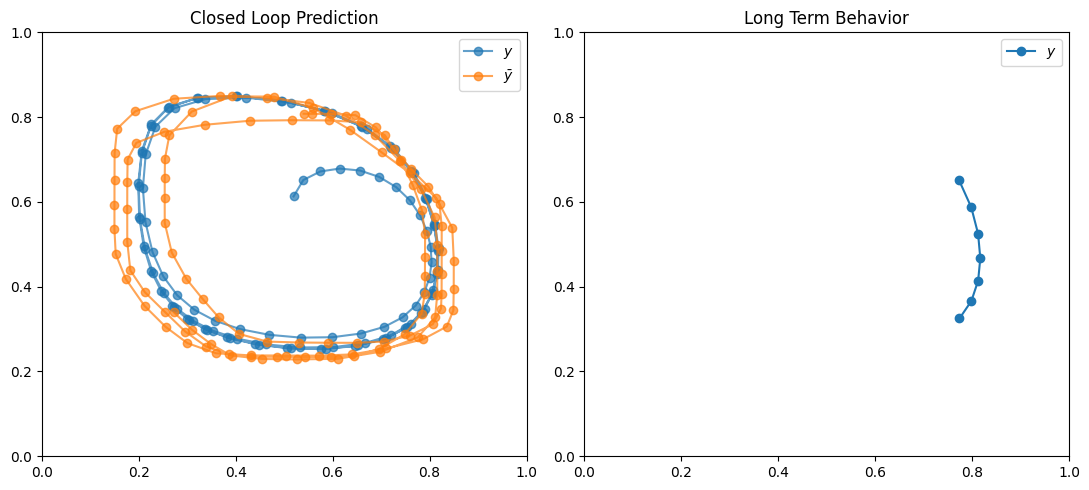

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))

nSteps = 200

predictArr = closedLoop(model, inputArr[0,0], nSteps)

ax[0].plot(predictArr[0,1:targetArr.shape[1],0], predictArr[0,1:targetArr.shape[1],1], '-o', alpha=.7, label='$ y $')
ax[0].plot(targetArr[0,1:,0], targetArr[0,1:,1], '-o', alpha=.7, label=r'$\bar y$')
ax[0].legend()
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_title('Closed Loop Prediction')

ax[1].plot(predictArr[0,-nSteps//30:,0], predictArr[0,-nSteps//30:,1], '-o', label='$ y $')
ax[1].legend()
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_title('Long Term Behavior')

fig.tight_layout()
#plt.savefig('images/circle_cl.png')
plt.show()

In [40]:
predictArr.shape

(1001, 1, 2)